---
title: "2023_Kronensicherung_Plesse_Analyse_Kraft"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Analyse_Kraft

## Kombinierte Analyse LineScale3, TreeQinetic und Versuchsaufzeichung

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment).

## Arbeitsumgebung vorbereiten

### IMPORT: Packages

In [1]:
# Struktur & Typen
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import json
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from slugify import slugify  # Zum Vereinheitlichen von Strings

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistik
from scipy.stats import linregress, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

In [2]:
# Eigene Module und Funktionen
from kj_core.utils.latex_export import (
    generate_latex_table,
    generate_grouped_latex_tables,
    save_latex_table,
    build_data_dict_df
)
from kj_core.utils.labeling import (
    get_label_from_dict,
    get_color_dict
)
from kj_core import (
    CoreConfig,
    PlotManager,
    get_logger
)

# Projekteinstellungen
from project_config import (
    working_directory,
    data_export_directory,
    latex_export_directory,
    filename_clean_dataset,
    filename_clean_data_dict
)

### IMPORT: Manager Instanzen

In [3]:
logger = get_logger(__name__)
CONFIG = CoreConfig(working_directory=f"{working_directory}/combined")
PLOT_MANAGER = PlotManager(CONFIG)

2025-08-26 15:56:37 [WARNING] kj_core.core_config.set_working_directory: The directory C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined already exists.
2025-08-26 15:56:37 [INFO] kj_core.core_config.set_working_directory: Working directory set to C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined!
2025-08-26 15:56:37 [INFO] kj_core.core_config.__init__: <CoreConfig>
  Package:            kj_core
  Working Directory:  C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined
  Plot Directory:     C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\combined\plots
  Data Directory:     C:\kyellsen\005_Projekte\2024

## IMPORT: Daten Import

In [4]:
# Dateien laden
df = pd.read_feather(data_export_directory / filename_clean_dataset)

with open(data_export_directory / filename_clean_data_dict, "r", encoding="utf-8") as f:
    data_dict = json.load(f)

## ANALYSE: Explorative Datenanalyse

In [5]:
df.head(3)

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max_force,cable_integral,sensor_name,location,direction,...,frequency_damped,phase_angle,y_shift,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae
4,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,0.0,Elasto(90),StB,elongation,...,0.441518,0.2,-5.287164,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011
5,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,0.0,Elasto(92),StB,elongation,...,0.432441,-0.2,-14.233644,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183
6,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,0.0,Elasto(95),StA,elongation,...,0.422702,-0.2,-19.011309,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274


In [6]:
df.columns

Index(['id', 'rope_datetime', 'treatment', 'release_force_target',
       'rope_release', 'cable_max_force', 'cable_integral', 'sensor_name',
       'location', 'direction', 'height', 'diameter', 'max_strain',
       'max_compression', 'integral_intercept', 'integral_positiv',
       'integral_negativ', 'integral_abs', 'integral_ratio', 'm_amplitude',
       'm_amplitude_2', 'initial_amplitude', 'damping_coeff',
       'frequency_damped', 'phase_angle', 'y_shift', 'x_shift',
       'frequency_undamped', 'damping_ratio', 'metrics_warning', 'pearson_r',
       'nrmse', 'nmae'],
      dtype='object')

### COMBINED: Definition von Darstellungsstandards
Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [7]:
color_palette = PLOT_MANAGER.color_palette_list

# Für die Spalte "treatment":
treatment_color_dict = get_color_dict(df, "treatment", PLOT_MANAGER.color_palette_list)

Index(['free', 'gefa_dynamic', 'cobra_static'], dtype='object')


### LS3 ANALYSE: Zusammenhang Vorspannung und Lastspitze KS

In [8]:
# Funktion zur Erstellung des Text-Strings für die statistischen Parameter
def annotate_stats(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    text_str = f"R = {r_value:.4f}\nSlope = {slope:.4f}\nIntercept = {intercept:.2f}\np-value = {p_value:.2e}\nStd Err = {std_err:.2f}"
    return text_str

In [9]:
df_grouped_by_id = (
    df[['id', 'treatment', 'release_force_target', 'rope_release', 'cable_max_force', 'cable_integral', 'integral_abs', 'integral_ratio']]
    .groupby('id', observed=False)
    .agg(
        treatment            = ('treatment',        'first'),
        release_force_target = ('release_force_target','first'),
        rope_release         = ('rope_release',     'first'),
        cable_max_force            = ('cable_max_force',        'first'),
        cable_integral       = ('cable_integral',   'first'),
    )
    .reset_index()
)
df_grouped_by_id

,id,treatment,release_force_target,rope_release,cable_max_force,cable_integral
0,2,free,2.8,2.72310,NaN,0.000000
1,3,free,2.8,2.76205,NaN,0.000000
2,4,free,2.8,2.73950,NaN,0.000000
3,5,free,2.4,2.36475,NaN,0.000000
4,6,free,2.4,2.38000,NaN,0.000000
5,7,free,2.4,2.36920,NaN,0.000000
6,8,free,2.0,1.96440,NaN,0.000000
7,9,free,2.0,1.97830,NaN,0.000000
8,10,free,2.0,1.94680,NaN,0.000000
9,11,gefa_dynamic,2.8,2.75785,1.48,1.114957


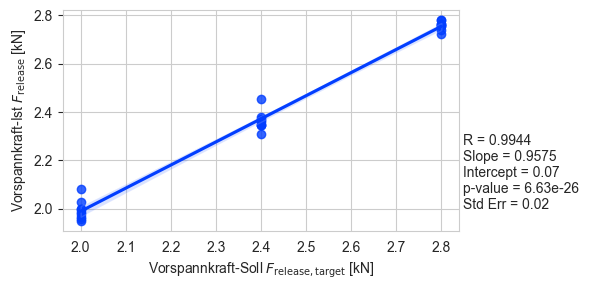

In [10]:
data_df = df_grouped_by_id
x_var = 'release_force_target'
y_var = 'rope_release'

fig, ax1 = plt.subplots(figsize=(6, 3))
sns.regplot(data=data_df, x=x_var, y=y_var, ax=ax1, ci=95)
ax2 = ax1.twinx()
ax2.axis('off')
stats_text = annotate_stats(data_df[x_var], data_df[y_var])
ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
#ax1.set_title(f'Regression zwischen {get_label_from_dict(x_var, data_dict)} und {get_label_from_dict(y_var, data_dict)}')
ax1.set_xlabel(get_label_from_dict(x_var, data_dict, use_full=True))
ax1.set_ylabel(get_label_from_dict(y_var, data_dict, use_full=True))
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename=f"{x_var}_vs_{y_var}", subdir="ls3_regression")

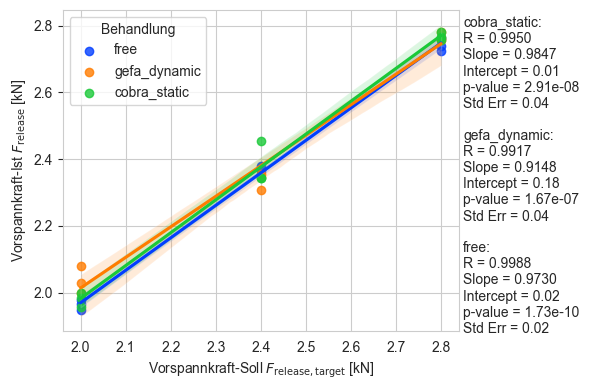

In [11]:
data_df = df_grouped_by_id
group_by = 'treatment'
x_var = 'release_force_target'
y_var = 'rope_release'

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1

for idx, (group, color) in enumerate(treatment_color_dict.items()):
    group_df = df_grouped_by_id[df_grouped_by_id[group_by] == group]
    # Sicherstellen, dass in beiden Variablen Werte vorhanden sind
    if group_df[x_var].isna().all() or group_df[y_var].isna().all():
        continue
    sns.regplot(x=x_var, y=y_var, data=group_df, ax=ax1, color=color, label=group, ci=95)
    stats_text = annotate_stats(group_df[x_var], group_df[y_var])
    ax2.annotate(f"{group}:\n{stats_text}", xy=(1.01, y_pos_init + ((idx-0.3) * 0.35)), xycoords='axes fraction')
    
#ax1.set_title(f'Regression zwischen {get_label_from_dict(x_var, data_dict)} und {get_label_from_dict(y_var, data_dict)}')
ax1.set_xlabel(get_label_from_dict(x_var, data_dict, use_full=True))
ax1.set_ylabel(get_label_from_dict(y_var, data_dict, use_full=True))
ax1.legend(title=get_label_from_dict(group_by, data_dict), loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename=f"{x_var}_vs_{y_var}_grouped_by_{group_by}", subdir="ls3_regression")


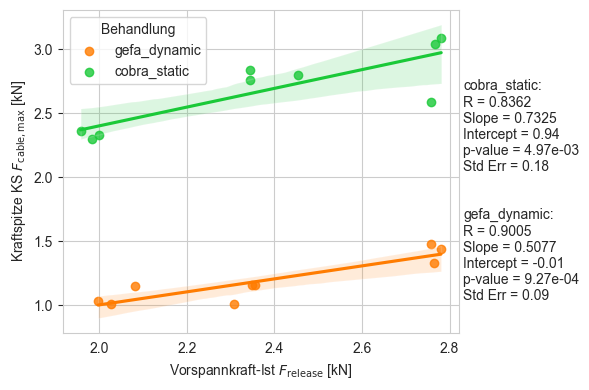

In [12]:
data_df = df_grouped_by_id
group_by = 'treatment'
x_var = 'rope_release'
y_var = 'cable_max_force'

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (group, color) in enumerate(treatment_color_dict.items()):
    group_df = df_grouped_by_id[df_grouped_by_id[group_by] == group]
    if group_df[y_var].isna().all():
        continue
    sns.regplot(x=x_var, y=y_var, data=group_df, ax=ax1, color=color, label=group, ci=95)
    stats_text = annotate_stats(group_df[x_var], group_df[y_var])
    ax2.annotate(f"{group}:\n{stats_text}", xy=(1.01, y_pos_init + ((idx - 1) * 0.4)), xycoords='axes fraction')
#ax1.set_title(f'Regression zwischen {get_label_from_dict(x_var, data_dict)} und {get_label_from_dict(y_var, data_dict)}')
ax1.set_xlabel(get_label_from_dict(x_var, data_dict, use_full=True))
ax1.set_ylabel(get_label_from_dict(y_var, data_dict, use_full=True))
ax1.legend(title=get_label_from_dict(group_by, data_dict), loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename=f"{x_var}_vs_{y_var}", subdir="ls3_regression")

### LS3 ANALYSE: Lastspitze in der KS

Analyse der Spitzenlasten in der KS gruppiert nach Ziel-Vorspannung und Treatment.

2025-08-26 15:56:42 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-26 15:56:42 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-26 15:56:42 [INFO] matplotlib.category.update: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\mail\AppData\Local\Temp\ipykernel_4824\1562228357.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=df_plot,
2025-08-26 15:56:

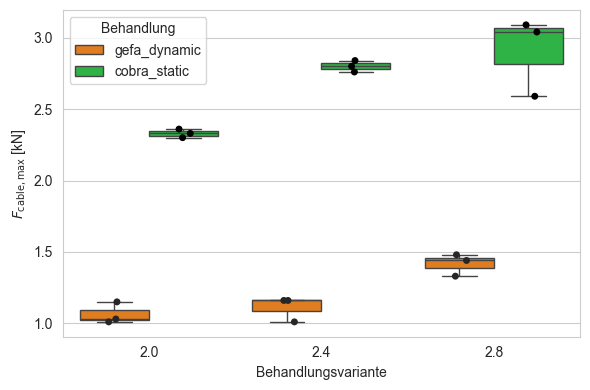

In [13]:
# Zuerst filtern wir alle Zeilen heraus, bei denen 'treatment' den Wert "free" hat.
df_plot = df_grouped_by_id[df_grouped_by_id['treatment'] != "free"].copy()

# Optional: Entferne die leere Kategorie "free" aus der ordered Kategorie, falls sie noch vorhanden ist.
df_plot['treatment'] = df_plot['treatment'].cat.remove_categories(["free"])

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_plot, 
            x='release_force_target', 
            y='cable_max_force', 
            hue='treatment',
            palette=treatment_color_dict,
            ax=ax)

# Stripplot (Einzeldaten)
sns.stripplot(data=df_plot,
              x='release_force_target',
              y='cable_max_force',
              hue='treatment',
              dodge=True,
              color='black',   # etwas abgesetzte Farbe
              alpha=1,       # halbe Transparenz
              ax=ax,
              legend=False)


# Setzt den Titel und die Achsenbeschriftungen entsprechend der Beschriftungsfunktion aus data_dict
#ax.set_title(f"{get_label_from_dict('cable_max_force', data_dict)} gruppiert nach {get_label_from_dict('treatment', data_dict)} und {get_label_from_dict('release_force_target', data_dict)}")
ax.set_xlabel("Behandlungsvariante")
ax.set_ylabel(get_label_from_dict('cable_max_force', data_dict, use_axes=True))
#ax.set_ylim(0, 3.2)
plt.tight_layout()
ax.legend(title="Behandlung")
plt.show()

PLOT_MANAGER.save_plot(fig, filename="cable_max_boxplot", subdir="ls3_boxplots")

In [14]:
# Daten filtern
filtered_df = df.query('treatment in ["gefa_dynamic", "cobra_static"]')[["release_force_target", "treatment", "cable_max_force"]]

# Gruppieren, Aggregieren und Pivotieren
pivoted = (
    filtered_df
    .groupby(['release_force_target', 'treatment'], observed=True)['cable_max_force']
    .agg(['min', 'mean', 'max'])
    .unstack(level=0)
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, False])
)

# Spaltennamen formatieren (Index Level 0: zwei Nachkommastellen)
pivoted.columns = pd.MultiIndex.from_tuples(
    [(f"{lvl0:.2f}", lvl1) if isinstance(lvl0, float) else (lvl0, lvl1)
     for lvl0, lvl1 in pivoted.columns],
    names=pivoted.columns.names
)
pivoted

release_force_target  2.00                  2.40              2.80            \
                       min      mean   max   min  mean   max   min      mean   
treatment                                                                      
gefa_dynamic          1.01  1.063333  1.15  1.01  1.11  1.16  1.33  1.416667   
cobra_static          2.30  2.330000  2.36  2.76  2.80  2.84  2.59  2.906667   

release_force_target        
                       max  
treatment                   
gefa_dynamic          1.48  
cobra_static          3.09

In [15]:
# Achsenbeschriftungen setzen
pivoted.columns.set_names(
    [get_label_from_dict("release_force_target", data_dict, template="{Zeichen}"), None],
    inplace=True
)
pivoted.index.set_names(
    get_label_from_dict("treatment", data_dict),
    inplace=True
)

In [16]:
latex_string = pivoted.to_latex(index=True, escape=True, float_format="{:0.2f}".format, column_format="l|rrr|rrr|rrr", multicolumn=True,
    multicolumn_format="c")

# Beschriftung erstellen
caption = "Plesse - Ergebnisse, Kraftspitze in der KS"
caption_long = (
    f"Plesse - {get_label_from_dict('cable_max_force', data_dict, use_full=True)} "
    f"gruppiert über {get_label_from_dict('release_force_target', data_dict, use_full=True)} und "
    f"{get_label_from_dict('treatment', data_dict)}. "
    f"Angegeben ist jeweils pro Gruppe das Minimum, der Mittelwert und das Maximum. "
    f"Die Variante 'free' ist nicht aufgeführt, da hier keine KS eingesetzt wurde."
)

# LaTeX-Tabelle speichern
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\plesse_ergebnisse_kraftspitze_in_der_ks.tex


In [17]:
# ANOVA für 'ls3_rope_release'
model_rope_release = smf.ols('rope_release ~ treatment', data=df_grouped_by_id).fit()
anova_rope_release = sm.stats.anova_lm(model_rope_release, typ=2)

# ANOVA für 'cable_max_force'
model_cable_max_force= smf.ols('cable_max_force ~ treatment', data=df_grouped_by_id).fit()
anova_cable_max_force = sm.stats.anova_lm(model_cable_max_force, typ=2)

# Zusammenfassungen der Modelle
summary_rope_release = model_rope_release.summary()
summary_cable_max_force = model_cable_max_force.summary()
# Zusammenfassungen der Modelle
summary_rope_release_latex = model_rope_release.summary().as_latex()
summary_cable_max_force_latex = model_cable_max_force.summary().as_latex()

#print(summary_rope_release_latex)
#print(summary_cable_max_force_latex)

anova_rope_release, summary_rope_release, anova_cable_max_force, summary_cable_max_force

C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\kyellsen\006_Packages\venv_Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


(             sum_sq    df         F    PR(>F)
 treatment  0.002315   2.0  0.010414  0.989645
 Residual   2.668025  24.0       NaN       NaN,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           rope_release   R-squared:                       0.001
 Model:                            OLS   Adj. R-squared:                 -0.082
 Method:                 Least Squares   F-statistic:                   0.01041
 Date:                Tue, 26 Aug 2025   Prob (F-statistic):              0.990
 Time:                        15:56:43   Log-Likelihood:                -7.0656
 No. Observations:                  27   AIC:                             20.13
 Df Residuals:                      24   BIC:                             24.02
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
        